In [1]:
import sys as sy
import numpy as np
import pandas as pd
import tushare as ts
#import pyecharts as pye
from sklearn import datasets as ds
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

# Optimization Application II: Portfolio Selection

In [2]:
# Read the stock data
df = pd.read_csv('stocks.csv')

In [3]:
#读入美的“000333”2017-01-01 到 2018-11-08复权后数据
#美的取了前复权数据
#ts.set_token('your token code')
#pro = ts.pro_api()
#df = pro.daily(ts_code='601318.SH, 600887.SH, 600609.SH, 600036.SH', start_date='20190101', end_date='20200101')

In [4]:
df2 = df[['ts_code','trade_date','close']]
#data = df2['close']
#df2['close']=data/data.ix[0]-1
df2['trade_date'] = pd.to_datetime(df2['trade_date'])
df2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ts_code,trade_date,close
0,600036.SH,2019-12-31,37.58
1,600609.SH,2019-12-31,3.96
2,600887.SH,2019-12-31,30.94
3,601318.SH,2019-12-31,85.46
4,600036.SH,2019-12-30,37.83


## Stock Price Visualization

In [5]:
df2 = df2.reset_index().set_index('trade_date')
df2 = df2.drop(['index'],axis=1)
df3 = df2.groupby('ts_code')
df3 = pd.pivot_table(df2,index=[u'trade_date',u'ts_code'])
df4 = df3.unstack()
df4.head()

close                              
ts_code    600036.SH 600609.SH 600887.SH 601318.SH
trade_date                                        
2019-01-02     24.57      3.09     22.48     55.18
2019-01-03     24.88      3.09     22.30     55.68
2019-01-04     25.51      3.14     22.52     56.59
2019-01-07     25.52      3.19     22.77     56.30
2019-01-08     25.22      3.18     22.60     55.80

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


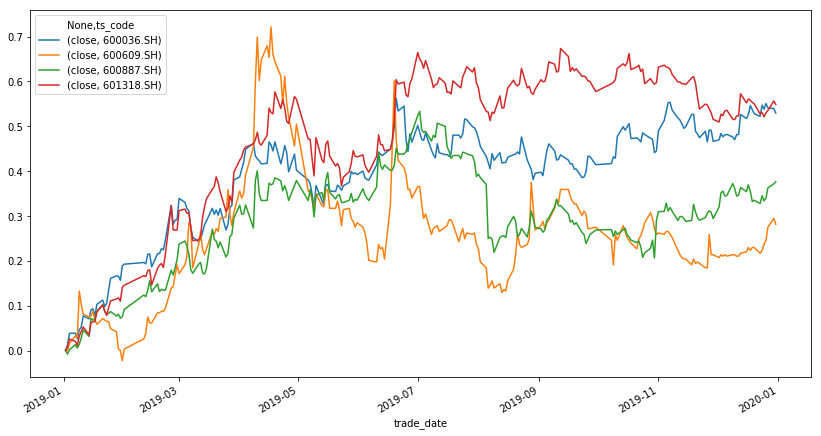

In [6]:
(df4/df4.ix[0]-1).plot(figsize=(14,7.5))

### Comparison of the log-return
$$R = log(S_t/S_{t-1})$$

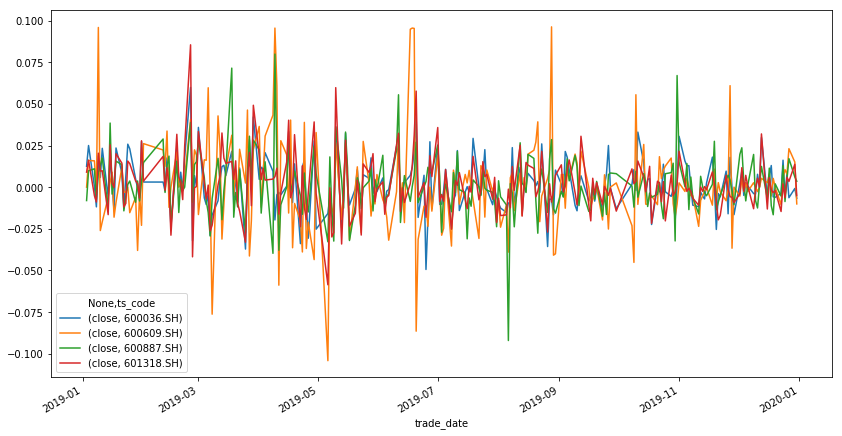

In [7]:
returns = np.log(df4/df4.shift(1))
returns.plot(figsize=(14,7.5))

In [8]:
# 1、定义随机权重函数
def weight(n):
    w=np.random.random(n)
    return w/sum(w)
weight(5)

array([0.34957244, 0.06867723, 0.08443671, 0.16120718, 0.33610645])

## 定义投资组合函数 ，给定收益率和各证券权重，计算组和的年化平均收益率、方差以及sharp率

In [9]:
# 采用2017年1年期国债作为无风险资产，年化收益率
rf = pd.read_csv('shibor.csv')
r_f = rf['1y']/100
#r_f=w.wss("019555.SH", "sec_name,couponrate", "").Data[1][0]/100
def portfolio(r,w):
    r_mean=r.mean()*252  #各证券的平均年化收益率
    p_mean=np.sum(r_mean*w)  #组合平均年化收益率
    r_cov=r.cov()*252  #各证券的协方差
    p_var=np.dot(w.T, np.dot(r_cov,w))  #计算组合的方差
    p_std=np.sqrt(p_var) #组合标准差
    p_sharpe=(p_mean-np.mean(r_f.values))/p_std
    return p_mean,p_std,p_sharpe
# 输出是均值，方差和夏普比 
portfolio(returns,weight(4))

(0.3959848741625899, 0.21333049433595047, 1.8547395204065535)

### 可视化期望与方差的关系

Text(0.5, 1.0, 'Mean and Std of Returns')

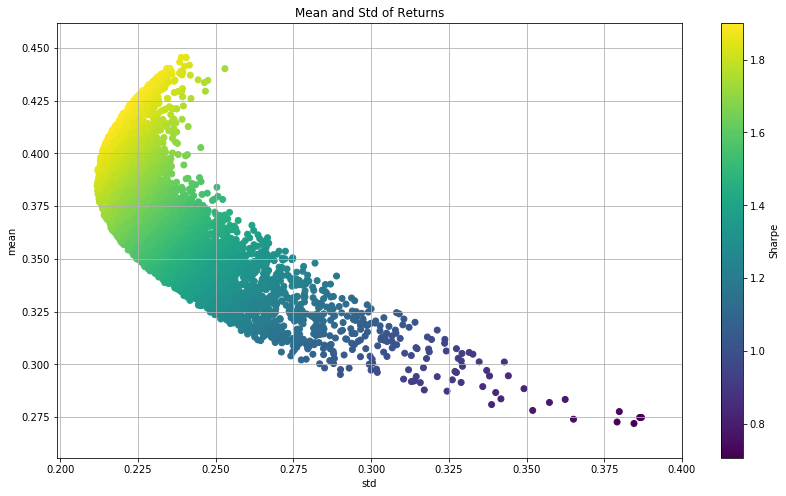

In [10]:
p_mean,p_std,p_sharpe=np.column_stack([portfolio(returns,weight(4)) for i in range(8000)]) #产生随机组合
plt.figure(figsize = (14,8))
plt.scatter(p_std, p_mean, c=p_sharpe, marker = 'o')
plt.grid(True)   #显示网格
plt.xlabel('std')
plt.ylabel('mean')
plt.colorbar(label = 'Sharpe')
plt.title('Mean and Std of Returns')

Text(0.5, 1.0, 'Mean and Std of Returns')

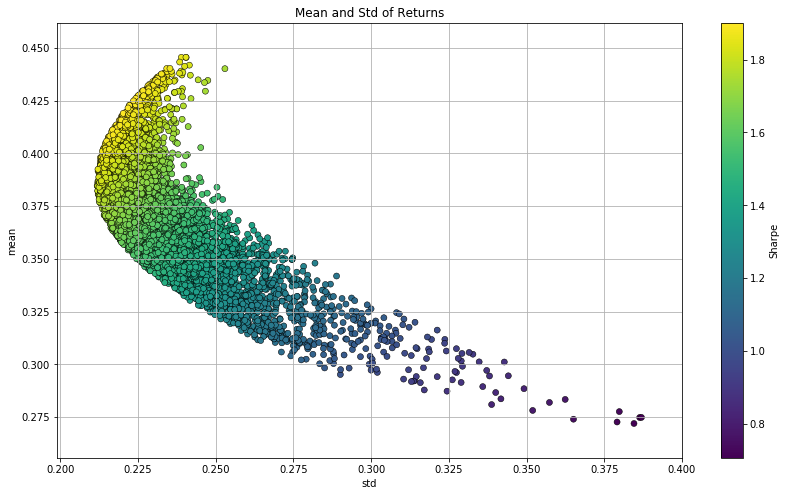

In [11]:
plt.figure(figsize = (14,8))
plt.scatter(p_std, p_mean, c=p_sharpe, marker = 'o',linewidths=0.5,edgecolors='black')
plt.grid(True)   #显示网格
plt.xlabel('std')
plt.ylabel('mean')
plt.colorbar(label = 'Sharpe')
plt.title('Mean and Std of Returns')

## 计算有效前沿

**目标函数：**   
$$ \large min\delta^2(r_p)= \sum\sum w_i w_j cov(r_i,r_j)= w^TVw $$

**限制条件：**

$$ \large \sum \omega_i =1,\omega_i\geq 0 （不允许卖空）$$

上式表明，在限制条件下求解 $\omega_i$ 使组合风险 $\delta^2(r_p)$ 最小，可通过拉格朗日目标函数求得:

$$ \large E(\ r_p)=\sum \omega_i \ r_i $$

In [12]:
from scipy.optimize import minimize 
t_returns=list(np.linspace(0.3,0.45,100)) #生成100个0.5~0.75下的等步长目标收益率
# 任给一个目标收益率(t_returns[2])，求最小标准差
def min_variance(w):
    return portfolio(returns,w)[1]**2  #定义一个最小方差函数
cons = ({'type':'eq','fun':lambda w:portfolio(returns,w)[0]-t_returns[2]},{'type':'eq','fun':lambda w:np.sum(w)-1})
res = minimize(min_variance,weight(4),bounds=((0,1),(0,1),(0,1),(0,1)),constraints = cons)
res  

     fun: 0.07526966173174254
     jac: array([0.04783995, 0.18586145, 0.12875772, 0.06675013])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([8.67361738e-19, 3.81439244e-01, 6.18560756e-01, 0.00000000e+00])

In [13]:
#在不同目标收益率水平（target_returnss)循环时，最小化的一个约束条件会变化
t_std = []
for t in t_returns:
    cons = ({'type':'eq','fun':lambda w:portfolio(returns,w)[0]-t},{'type':'eq','fun':lambda w:np.sum(w)-1})
    res = minimize(min_variance,weight(4),bounds=((0,1),(0,1),(0,1),(0,1)),constraints = cons)
    t_std.append(res['fun'])
t_std = np.sqrt(np.array(t_std))

array([0.27912414, 0.27661249, 0.27435317, 0.2722932 , 0.27026698,
       0.26826474, 0.26628702, 0.26433437, 0.26240734, 0.26050652,
       0.25863246, 0.25678577, 0.25496748, 0.25317685, 0.25141584,
       0.24968461, 0.24798379, 0.24631496, 0.24467589, 0.24307032,
       0.24149726, 0.23995803, 0.23845306, 0.236983  , 0.2355485 ,
       0.23415022, 0.23278881, 0.23146492, 0.2301792 , 0.22893229,
       0.22772493, 0.22655745, 0.22543077, 0.22434542, 0.22330244,
       0.22230158, 0.22134317, 0.22042896, 0.21955895, 0.21873365,
       0.21795362, 0.2172193 , 0.21653107, 0.21588968, 0.21529501,
       0.21474789, 0.21424866, 0.21379812, 0.21339489, 0.2130417 ,
       0.21273569, 0.21247988, 0.2122691 , 0.21209582, 0.21195963,
       0.21186228, 0.21180003, 0.21177674, 0.21179044, 0.21184246,
       0.21193083, 0.21205736, 0.21222096, 0.21242197, 0.21266018,
       0.21293602, 0.21324766, 0.21359668, 0.21398207, 0.21440394,
       0.21486201, 0.21535636, 0.2158853 , 0.21645083, 0.21705

Text(0.5, 1.0, 'Mean and Std of Returns')

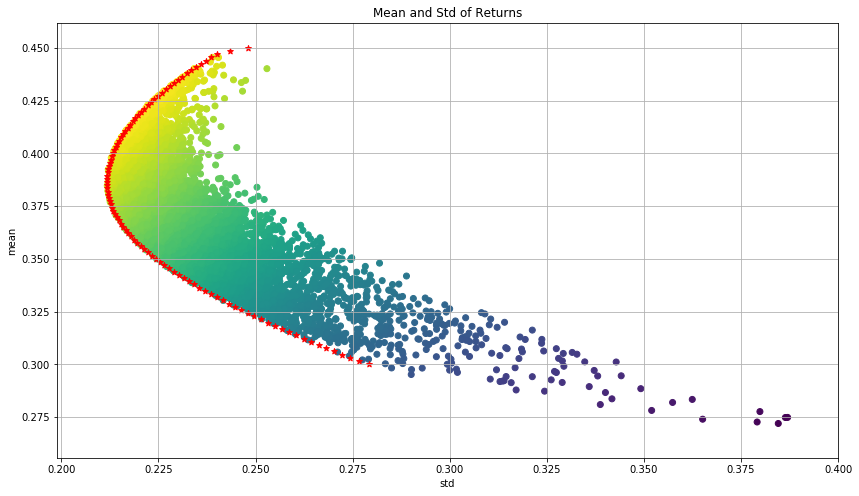

In [14]:
#下面是最优化结果的展示。
# 星号构成的曲线是有效前沿（目标收益率下最优的投资组合）
plt.figure(figsize = (14,8))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(p_std, p_mean, c=p_sharpe, marker = 'o')
#最小方差前沿
plt.scatter(t_std,t_returns, c = 'red',marker='*')
plt.grid(True)
plt.xlabel('std')
plt.ylabel('mean')
#plt.colorbar(label = 'Sharpe')
plt.title('Mean and Std of Returns')

Text(0.5, 1.0, 'Mean and Std of Returns')

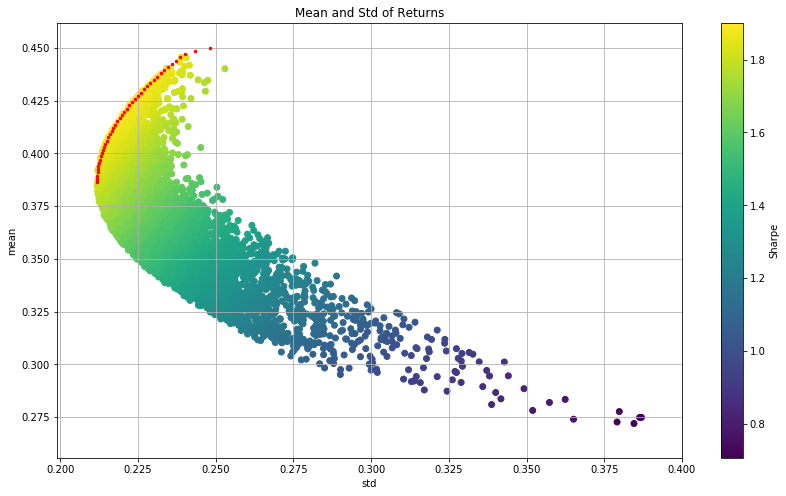

In [16]:
#选取最小方差值为起点构建有效前沿
ind=np.argmin(t_std)
e_std = t_std[ind:]
e_returns=t_returns[ind:]
plt.figure(figsize = (14,8))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(p_std, p_mean, c=p_sharpe, marker = 'o')
#最小方差组合
#plt.scatter(t_std,t_returns, c = (np.array(t_returns)-r_f)/t_std,marker = '*')
#有效前沿
plt.plot(e_std,e_returns,'r.',markersize=5)
plt.grid(True)
plt.xlabel('std')
plt.ylabel('mean')
plt.colorbar(label = 'Sharpe')
plt.title('Mean and Std of Returns')